# Topological comparison of connectomes
This is the main script for topological comparisons interfacing with the [topological_comparator](https://bbpgitlab.epfl.ch/conn/personal/reimann/topological_comparator.git) pipeline, which
 - sets up the topological comparator config files
 - creates a topological database
 - visualizes topological features of the raw and manipulated connectome

> **IMPORTANT:** This notebook is a stand-alone extension to `connectome_manipulator.ipynb`

> **REQUIREMENTS:**
> - BluePy v2 kernel!
> - topological_sampling/common/toposample_utilities/toposample
> - topological_sampling/common/pybind11
> - topological_sampling/common/pyflagsercontain

In [1]:
# Initialization
import sys
import json
import os.path
from pprint import pprint

""" Paths """
sys.path.insert(0, '../pipeline/')
sys.path.insert(0, '/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/')

""" Local imports """
from topological_sampling.pipeline.gen_topo_db import gen_topo_db
from topological_comparator.pipeline import prepare_pipeline
from topological_comparator.pipeline.extract_connectivity import extract_connectivity
from topological_comparator.bin import compare_topo_db
from helper_functions import topocomp_plot_comparison_combined

In [2]:
# Config selection
topocomp_config_file = '/gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/working_dir/topological_comparator/circuit-build-S1_v1/topocomp_config__Raw_vs_NoManipV2.json' 

In [3]:
# Load configuration from file
with open(topocomp_config_file, 'r') as f:
    topocomp_config = json.load(f)

print(f'INFO: Loaded topocomp_config from {topocomp_config_file}\n')
print('topocomp_config =')
pprint(topocomp_config)

INFO: Loaded topocomp_config from /gpfs/bbp.cscs.ch/home/pokorny/JupyterLab/git/connectome_manipulator/working_dir/topological_comparator/circuit-build-S1_v1/topocomp_config__Raw_vs_NoManipV2.json

topocomp_config =
{'circuits': {'0': {'circuit_config': '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1/CircuitConfig',
                    'circuit_name': 'Raw'},
              '1': {'circuit_config': '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1_manip/CircuitConfig_NoManipV2',
                    'circuit_name': 'NoManipV2'}},
 'out_dir': 'figures/circuit-build-S1_v1',
 'working_dir': '../working_dir/topological_comparator/circuit-build-S1_v1'}


In [4]:
# Topological comparison of connectomes - Prepare topological database
topocomp_force_recomp = [False, False]
topocomp_config_files = {}
circuit_ids = sorted(topocomp_config['circuits'].keys())
for cidx in range(len(circuit_ids)):
    wrkdir = os.path.join(topocomp_config['working_dir'], topocomp_config['circuits'][circuit_ids[cidx]]['circuit_name'])
    topocomp_config_files[circuit_ids[cidx]] = os.path.join(wrkdir, 'config', 'common_config.json')
    if os.path.exists(wrkdir) and not topocomp_force_recomp[cidx]:
        print(f'INFO: Folder {wrkdir} already exists ... SKIPPING', flush=True)
    else:
        print(f'INFO: Preparing pipeline in {wrkdir}', flush=True)
        prepare_pipeline.prepare_and_place_files(topocomp_config['circuits'][circuit_ids[cidx]]['circuit_config'], 'All', wrkdir)
        extract_connectivity.main(topocomp_config_files[circuit_ids[cidx]])
        gen_topo_db.main(topocomp_config_files[circuit_ids[cidx]])


INFO: Folder ../working_dir/topological_comparator/circuit-build-S1_v1/Raw already exists ... SKIPPING
INFO: Folder ../working_dir/topological_comparator/circuit-build-S1_v1/NoManipV2 already exists ... SKIPPING


Error occured when trying to compare Chung spectrum
Error occured when trying to compare Relative boundary
Error occured when trying to compare Euler characteristic
Error occured when trying to compare Betti two
Error occured when trying to compare Betti three
Error occured when trying to compare Transitive clustering coefficient
Error occured when trying to compare Normalized Betti coefficient
Error occured when trying to compare In-degree
Error occured when trying to compare Out-degree
Error occured when trying to compare Second density coefficient
Error occured when trying to compare Third density coefficient
Error occured when trying to compare Fourth density coefficient
Error occured when trying to compare Fifth density coefficient
Error occured when trying to compare Adjacency spectral gap (low)
Error occured when trying to compare Adjacency spectral gap (high)
Error occured when trying to compare Adjacency spectral radius
Error occured when trying to compare Afferent extension r

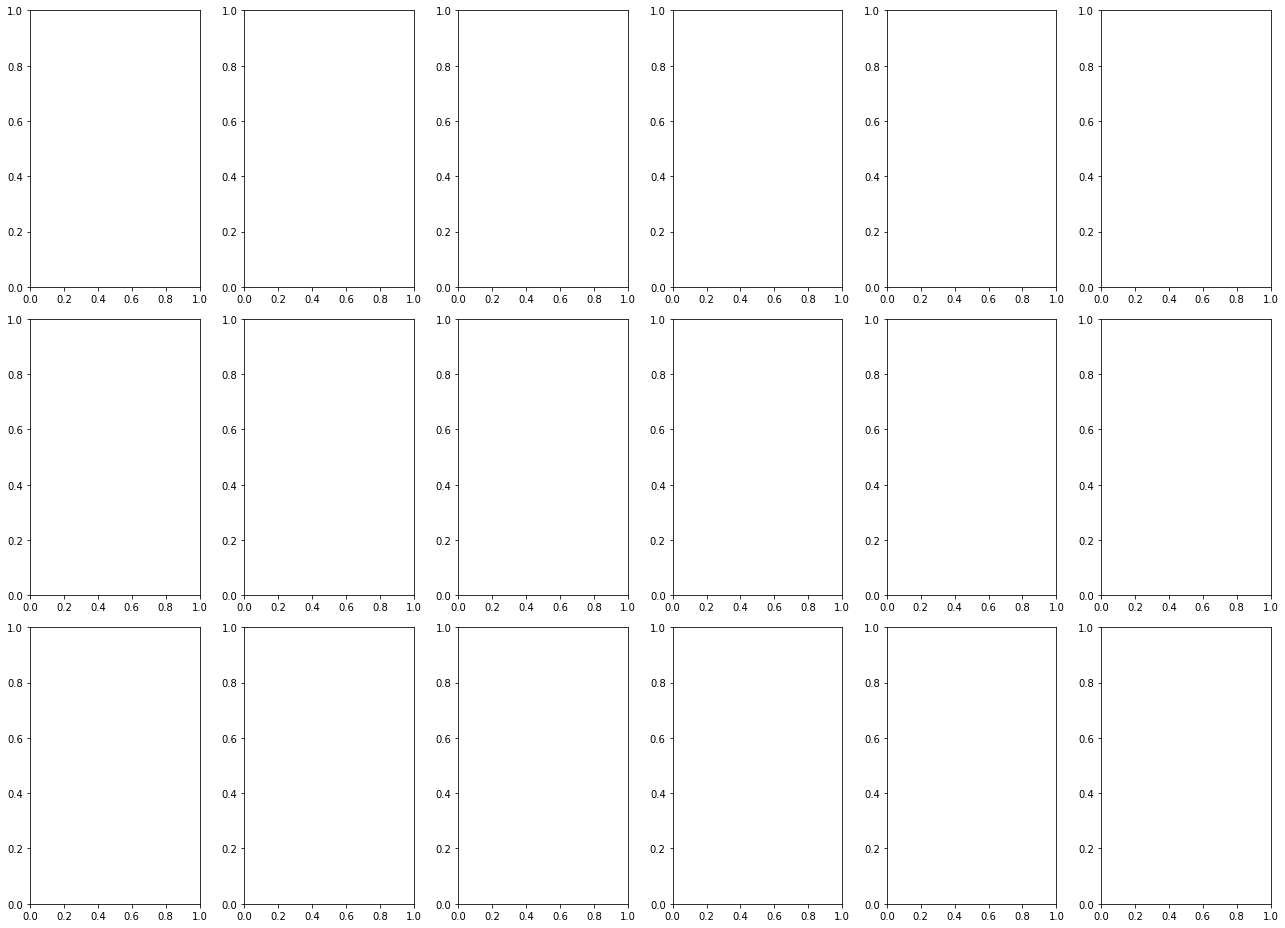

Error occured when trying to compare Chung spectrum
Error occured when trying to compare Relative boundary
Error occured when trying to compare Euler characteristic
Error occured when trying to compare Betti two
Error occured when trying to compare Betti three
Error occured when trying to compare Transitive clustering coefficient
Error occured when trying to compare Normalized Betti coefficient
Error occured when trying to compare In-degree
Error occured when trying to compare Out-degree
Error occured when trying to compare Second density coefficient
Error occured when trying to compare Third density coefficient
Error occured when trying to compare Fourth density coefficient
Error occured when trying to compare Fifth density coefficient
Error occured when trying to compare Adjacency spectral gap (low)
Error occured when trying to compare Adjacency spectral gap (high)
Error occured when trying to compare Adjacency spectral radius
Error occured when trying to compare Afferent extension r

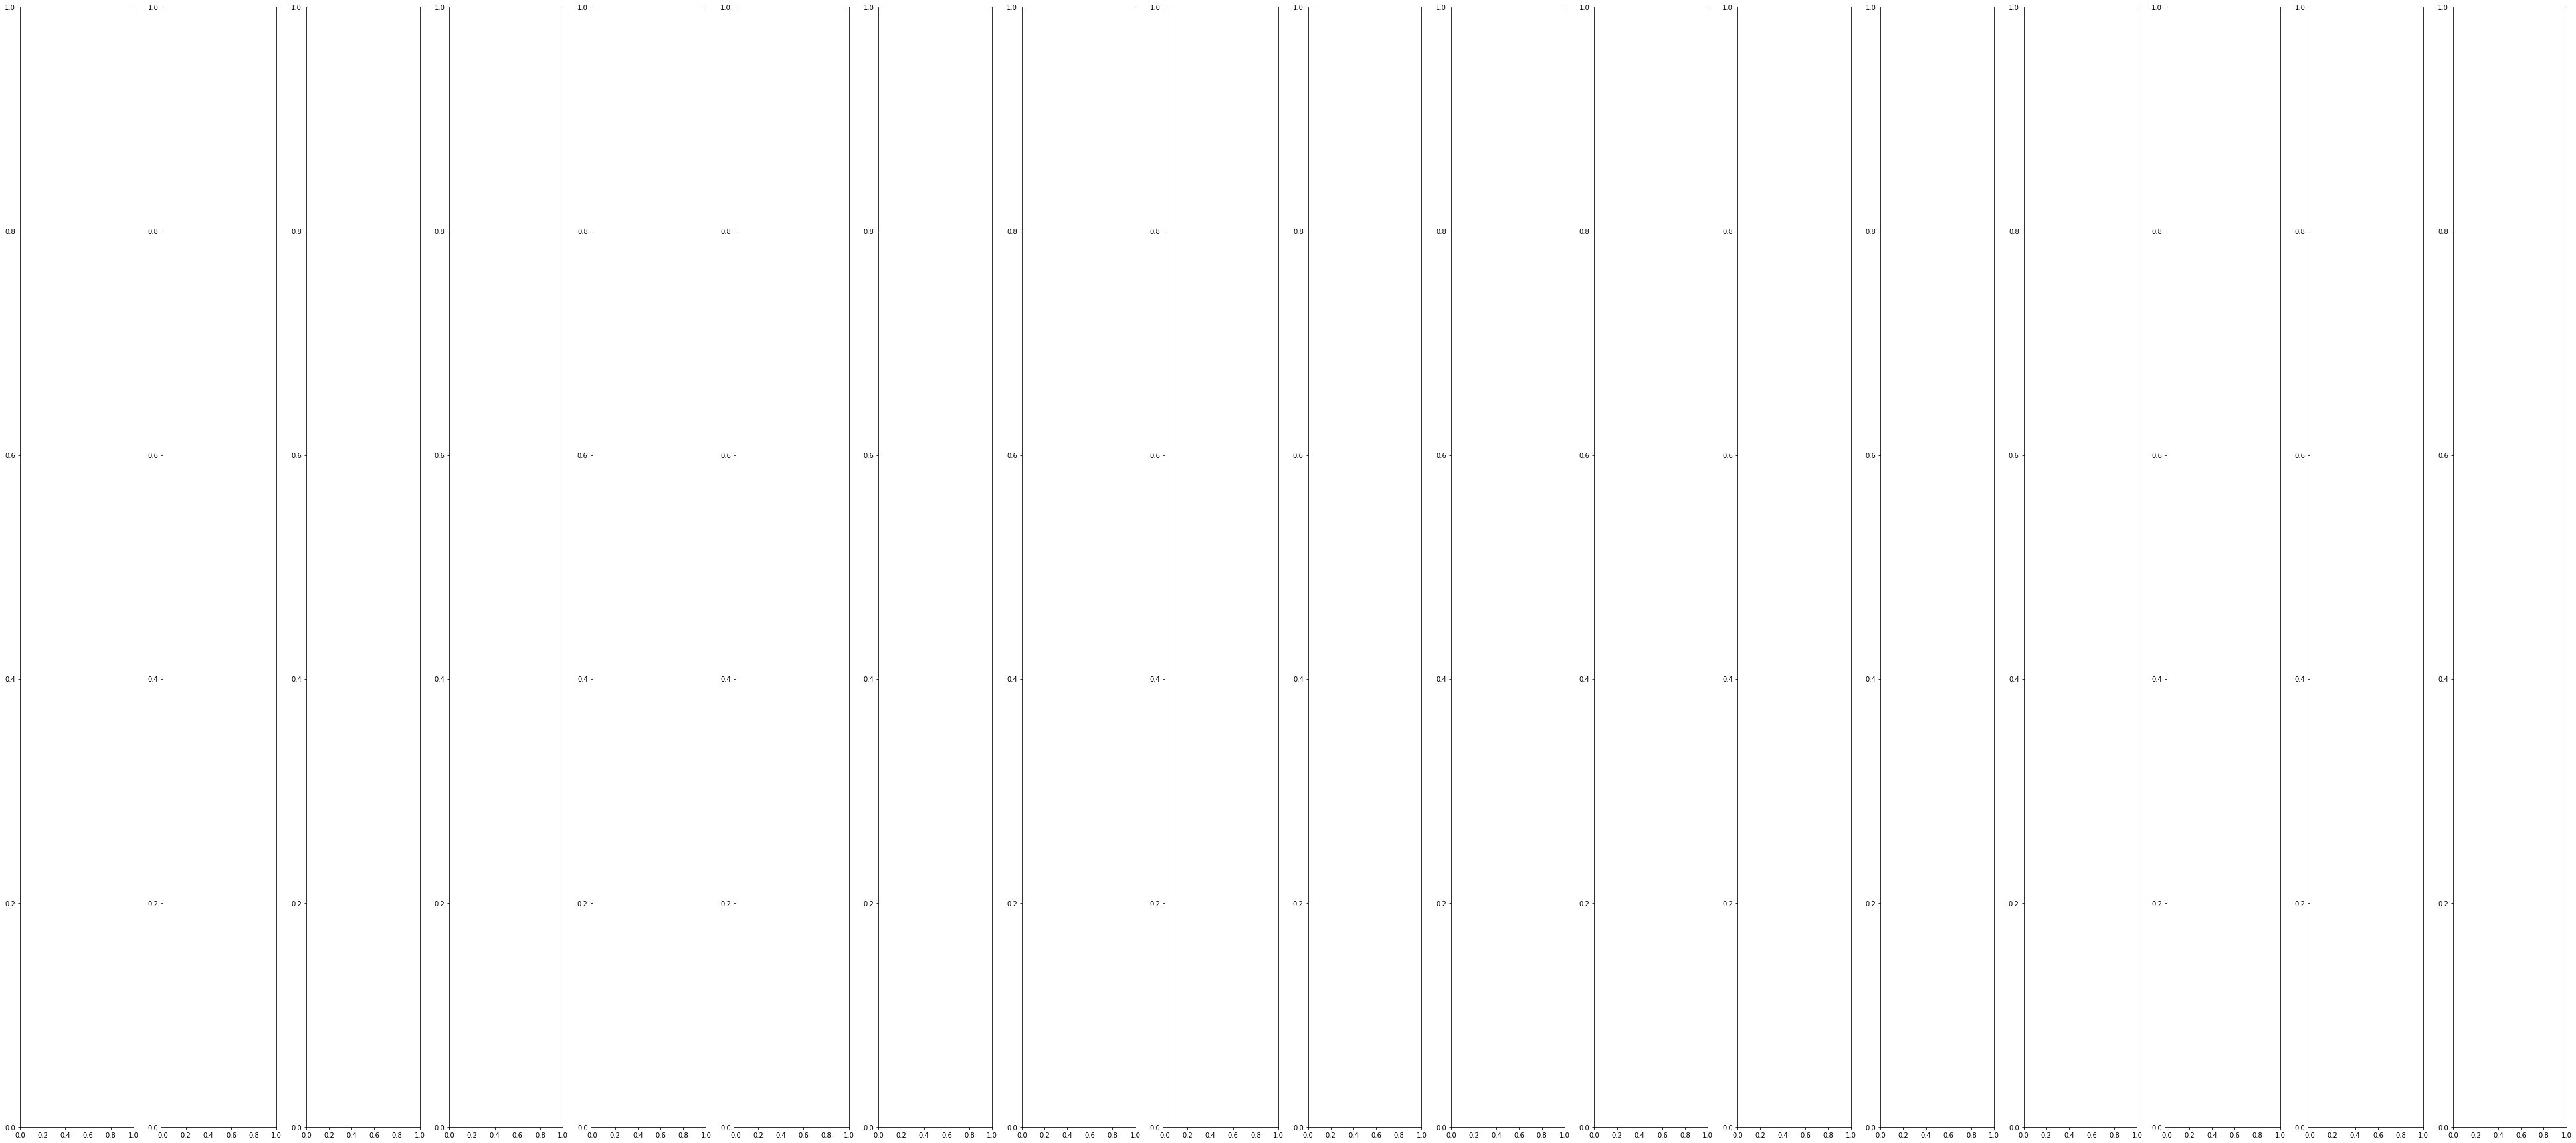

Error occured when trying to compare Chung spectrum
Error occured when trying to compare Relative boundary
Error occured when trying to compare Euler characteristic
Error occured when trying to compare Betti two
Error occured when trying to compare Betti three
Error occured when trying to compare Transitive clustering coefficient
Error occured when trying to compare Normalized Betti coefficient
Error occured when trying to compare In-degree
Error occured when trying to compare Out-degree
Error occured when trying to compare Second density coefficient
Error occured when trying to compare Third density coefficient
Error occured when trying to compare Fourth density coefficient
Error occured when trying to compare Fifth density coefficient
Error occured when trying to compare Adjacency spectral gap (low)
Error occured when trying to compare Adjacency spectral gap (high)
Error occured when trying to compare Adjacency spectral radius
Error occured when trying to compare Afferent extension r

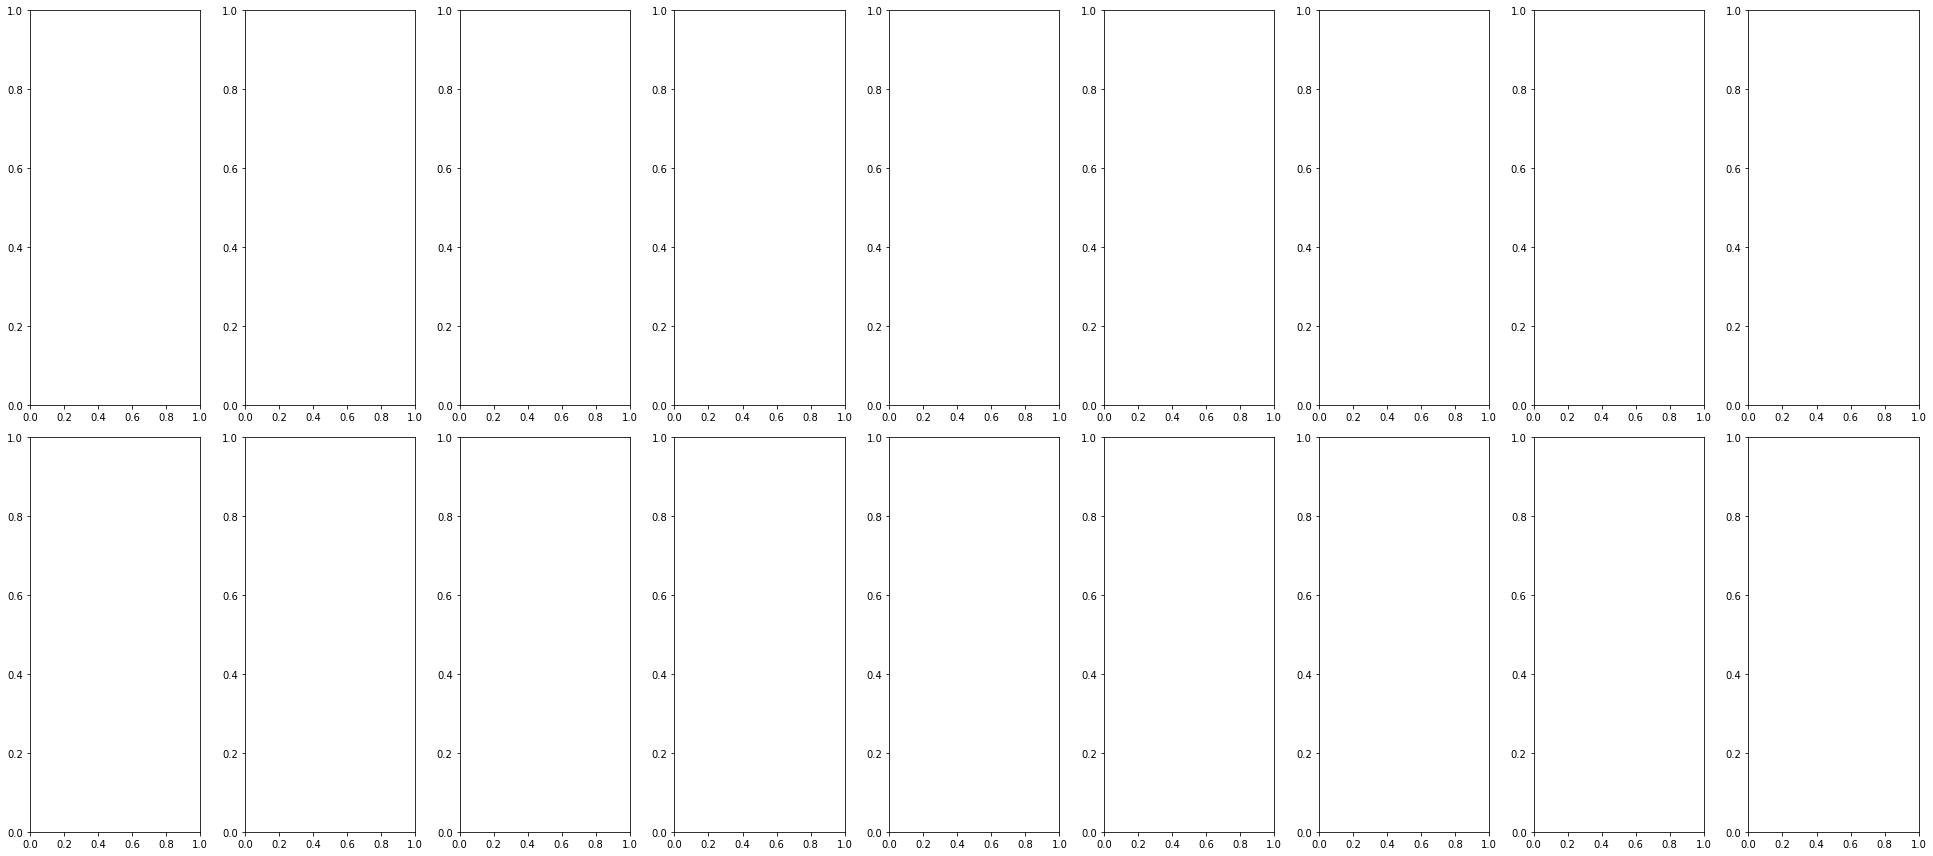

In [5]:
# Topological comparison of connectomes - Plot comparison
topocomp_db_dict, topocomp_param_dict = compare_topo_db.read_topo_dbs_and_parameter_specs({topocomp_config['circuits'][cidx]['circuit_name']: topocomp_config_files[cidx] for cidx in sorted(topocomp_config_files.keys())})
topocomp_plot_comparison_combined(topocomp_db_dict, topocomp_param_dict, '', topocomp_config['out_dir'], num_rows=3, show_fig=True)
topocomp_plot_comparison_combined(topocomp_db_dict, topocomp_param_dict, 'mtype', topocomp_config['out_dir'], num_rows=1, show_fig=True)
topocomp_plot_comparison_combined(topocomp_db_dict, topocomp_param_dict, 'layer', topocomp_config['out_dir'], num_rows=2, show_fig=True)
